## Using Vanilla CNN for baseline model prediction for Audio Classification tasks


### Data preprocessing step

Taken from first part of : https://github.com/krishnaik06/Audio-Classification/blob/main/Part%202-%20Audio%20Classification%20Data%20Preprocessing%20And%20Model%20Creation.ipynb


and

https://github.com/hasithsura/Environmental-Sound-Classification/blob/master/ESC50-Pytorch.ipynb


In [1]:
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
import random
import torchaudio
import torchaudio.transforms as transforms


print('success')

success


## Mount GDRIVE


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print(os.getcwd())

/content


In [4]:
# rileyqx2
!cp -a "/content/drive/MyDrive/Colab Notebooks/50.039 Deep Learning/Project/." "/content/"

cp: cannot open '/content/drive/MyDrive/Colab Notebooks/50.039 Deep Learning/Project/./Project Report.gdoc' for reading: Operation not supported


In [5]:
angry_path = './angry/'
disgusting_path = './disgusting/'
fear_path = './fear/'
happy_path = './happy/'
neutral_path = './neutral/'
sad_path = './sad/'


# Getting files into a list
from os import listdir
from os.path import isfile, join
angryfiles = [f for f in listdir(angry_path) if isfile(join(angry_path, f))]
disgustingfiles = [f for f in listdir(disgusting_path) if isfile(join(disgusting_path, f))]
fearfiles = [f for f in listdir(fear_path) if isfile(join(fear_path, f))]
happyfiles = [f for f in listdir(happy_path) if isfile(join(happy_path, f))]
neutralfiles = [f for f in listdir(neutral_path) if isfile(join(neutral_path, f))]
sadfiles = [f for f in listdir(sad_path) if isfile(join(sad_path, f))]



## Preprocess and show on a plot

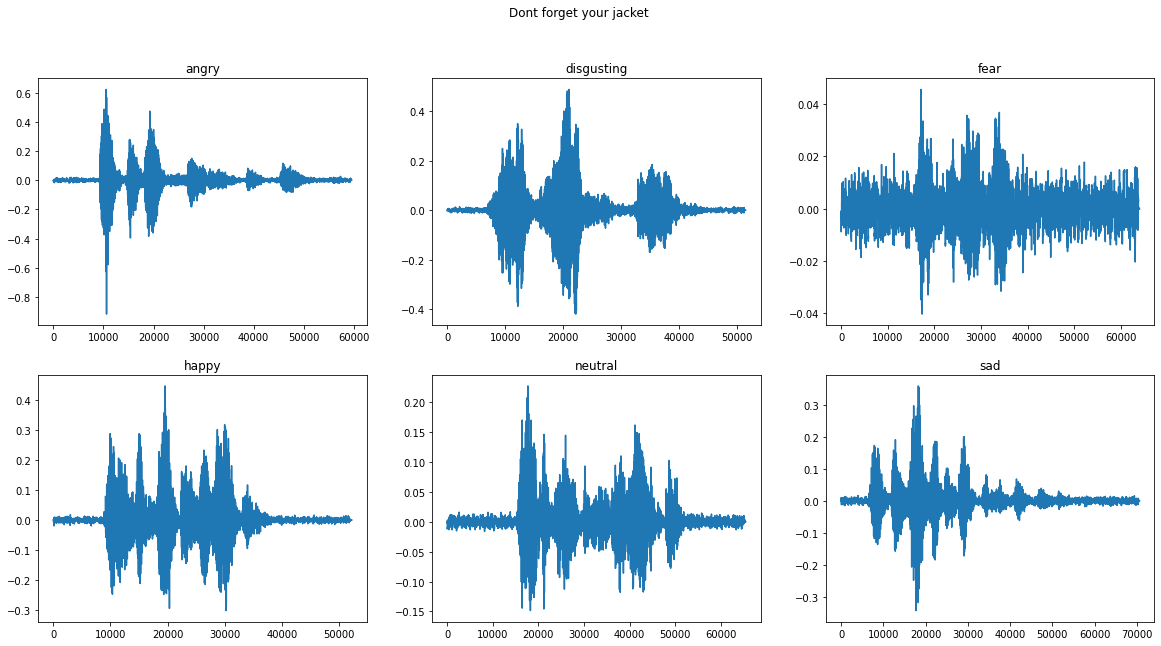

In [6]:
angry_one = angry_path + angryfiles[0]
angry_audio_data,angry_sample_rate=librosa.load(angry_one)
disgusting_one = disgusting_path + disgustingfiles[0]
disgusting_audio_data,disgusting_sample_rate=librosa.load(disgusting_one)
fear_one = fear_path + fearfiles[0]
fear_audio_data,fear_sample_rate=librosa.load(fear_one)
happy_one = happy_path + happyfiles[0]
happy_audio_data,happy_sample_rate=librosa.load(happy_one)
neutral_one = neutral_path + neutralfiles[0]
neutral_audio_data,neutral_sample_rate=librosa.load(neutral_one)
sad_one = sad_path + sadfiles[0]
sad_audio_data,sad_sample_rate=librosa.load(sad_one)




plt.rcParams["figure.figsize"] = (20,10)
fig, ((ax1, ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3)
fig.suptitle('Dont forget your jacket')

ax1.plot(angry_audio_data)
ax1.title.set_text('angry')
ax2.plot(disgusting_audio_data)
ax2.title.set_text('disgusting')
ax3.plot(fear_audio_data)
ax3.title.set_text('fear')
ax4.plot(happy_audio_data)
ax4.title.set_text('happy')
ax5.plot(neutral_audio_data)
ax5.title.set_text('neutral')
ax6.plot(sad_audio_data)
ax6.title.set_text('sad')

In [7]:
# Testing torchaudio, to be removed when the time comes




## Audio data augmentation 

In [8]:
# time shift
def time_shift(aud, shift_limit):
  sig_len = aud.shape[0]
  shift_amt = int(random.random() * shift_limit * sig_len)
  return np.roll(aud,shift_amt)

# noising
def noising(data, noise_factor):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

# pitch manipulation
def pitch_manipulate(data,sr, pitch_factor):
  return librosa.effects.pitch_shift(data, sr, pitch_factor)

# speed manipulation
def speed_manipulate(data, speed_factor):
  return librosa.effects.time_stretch(data, speed_factor)

## Display visualization in a spectogram

In [9]:
def pad_trunc(aud, max_ms):
  sig, sr = aud
  sig_len = sig.shape[0]
  max_len = sr//1000 * max_ms # max len should always be 22050//1000 * 3000

  sig = torch.Tensor(sig)
  sig = sig.view(1,-1) # reshape tensor to fit pad_begin and pad_end
  if (sig_len > max_len):
    # Truncate the signal to the given length
    sig = sig[:,:max_len]

      # process back to numpy array to be fed as input.
    sig = torch.flatten(sig)
    sig = sig.numpy()

  elif (sig_len < max_len):
    # Length of padding to add at the beginning and end of the signal
    pad_begin_len = random.randint(0, max_len - sig_len)
    pad_end_len = max_len - sig_len - pad_begin_len

    # Pad with 0s
    pad_begin = torch.zeros((1, pad_begin_len))
    pad_end = torch.zeros((1, pad_end_len))

  # process back to numpy array to be fed as input.
    sig = sig.view(1,-1) # reshape tensor to fit pad_begin and pad_end

    sig = torch.cat((pad_begin, sig, pad_end), 1)
    sig = torch.flatten(sig)
    sig = sig.numpy()
      
  return (sig, sr)

def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

def get_audio(file_path, sr=22050, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  # wav,sr = librosa.load(file_path,sr=sr)
  wav,sr = librosa.load(file_path,sr=sr,mono=True)
  wav,sr = pad_trunc((wav,sr),max_ms=3000) #pad all to about 5000 
  
  # Data Augmentations
  # wav = noising(wav,0.5) # apply noising data augmentation
  # wav = time_shift(wav,2) # apply timeshift data augmentation
  # wav = pitch_manipulate(wav,sr,2) # apply pitch data augmentation
  # wav = speed_manipulate(wav,1.25) # apply speed data augmentation

  # Resizes all images to same shape[1]
  # if wav.shape[0]<3*sr:
  #   wav=np.pad(wav,int(np.ceil((3*sr-wav.shape[0])/2)),mode='reflect')
  # else:
  #   wav=wav[:3*sr]

  # Produce spectrogram
  # spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
  #             hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
  # spec_db=librosa.power_to_db(spec,top_db=top_db)
  return wav[np.newaxis,...]

In [10]:
import librosa.display

In [11]:
angry = get_audio(angry_one)
print(angry.shape)


(1, 66000)


In [12]:
disgusting = get_audio(disgusting_one)
print(disgusting.shape)

(1, 66000)


In [13]:
fear = get_audio(fear_one)
print(fear.shape)

(1, 66000)


In [14]:
happy = get_audio(happy_one, happy_sample_rate)
print(happy.shape)


(1, 66000)


In [15]:
neutral = get_audio(neutral_one, sad_sample_rate)
print(neutral.shape)


(1, 66000)


In [16]:
sad = get_audio(sad_one, sad_sample_rate)
print(sad.shape)


(1, 66000)


# Create dataloaders

In [17]:
print(len(angryfiles),len(sadfiles),len(disgustingfiles),len(neutralfiles),len(fearfiles),len(happyfiles))

1087 1087 1087 1087 1087 1087


In [18]:
# This will take awhile
data = []
all_files = [angryfiles,sadfiles,disgustingfiles,neutralfiles,fearfiles,happyfiles]
all_paths = ['angry','sad','disgusting','neutral','fear','happy']
all_directories = [angry_path,sad_path,disgusting_path,neutral_path,fear_path,happy_path]

for i in range(len(all_files)):
    for j in range(len(all_files[i])):
        data.append([all_files[i][j],all_paths[i]])

data = pd.DataFrame(data,columns=['name','class'])

In [19]:
print(data)

                     name  class
0     1028_ITS_ANG_XX.wav  angry
1     1024_IEO_ANG_LO.wav  angry
2     1063_TAI_ANG_XX.wav  angry
3     1042_IWW_ANG_XX.wav  angry
4     1003_TAI_ANG_XX.wav  angry
...                   ...    ...
6517  1074_IEO_HAP_HI.wav  happy
6518  1019_TAI_HAP_XX.wav  happy
6519  1006_IWW_HAP_XX.wav  happy
6520  1067_ITH_HAP_XX.wav  happy
6521  1067_IOM_HAP_XX.wav  happy

[6522 rows x 2 columns]


In [20]:
class AudioData(Dataset):
  def __init__(self, df):
    self.df = df
    self.data = []
    self.labels = []
    self.c2i={}
    self.i2c={}
    self.categories = sorted(['angry','sad','disgusting','neutral','fear','happy'])
    for i, category in enumerate(self.categories):
      self.c2i[category]=i
      self.i2c[i]=category
    for ind in tqdm(range(len(df))):
      row = df.iloc[ind]
      file_path = './' + row['class'] + '/' + row['name']
      self.data.append(get_audio(file_path))
      self.labels.append(self.c2i[row['class']])
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [21]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(data, test_size=0.2,shuffle = True)

In [22]:
train_data = AudioData(train)
valid_data = AudioData(valid)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/5217 [00:00<?, ?it/s]

  0%|          | 0/1305 [00:00<?, ?it/s]

In [23]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

## Setup torch for training 

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
 # device = torch.device('cpu')
print(device)

seed = 0
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

cuda:0


## Create the model

In [25]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) # if bidirectional = True, then multiply x 2
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [26]:
in_size = 66000
hidden_size= 20
num_layers = 2
num_classes = 6

model = RNN(in_size,hidden_size,num_layers,num_classes) # 2 layer lstm
model = model.cuda() # if GPU avail

## Set other parameters


1.   Vary different multi class loss functions
2.   Vary optimizer for faster reach of minimum loss



In [27]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9)
# optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)

train_accu = []
train_losses = []
eval_accu = []
eval_loss = []

In [28]:
def train(epoch):
  print('\nEpoch : %d'%epoch)
  
  model.train()
  
  running_loss=0
  correct=0
  total=0


  for data in tqdm(train_loader):
    # print(data[0],data[1])
    inputs,labels=data[0].to(device),data[1].to(device)
    
    inputs,label=inputs.cuda(),labels.cuda()
    
    optimizer.zero_grad()
    outputs = model(inputs.float())
    # print(outputs)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    
    _, predicted = outputs.max(1)
    # print(predicted,label)

    # print(labels,predicted) # Checking the ground truths
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  train_loss=running_loss/len(train_loader)
  accu=100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

In [29]:
def test(epoch):
  print('\nEpoch : %d'%epoch)
  model.eval()

  running_loss=0
  correct=0
  total=0



  with torch.no_grad():
    for data in tqdm(valid_loader):
      inputs,labels=data[0].to(device),data[1].to(device)
      inputs,label=inputs.cuda(),labels.cuda()
      
      outputs=model(inputs.float())
      
      criterion = nn.CrossEntropyLoss()
      loss= criterion(outputs,labels)
      running_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  test_loss=running_loss/len(valid_loader)
  accu=100.*correct/total

  eval_loss.append(test_loss)
  eval_accu.append(accu)

  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 


In [30]:
epochs=50

for epoch in range(1,epochs+1): 
  train(epoch)
  test(epoch)
  print("best test accuracy =",max(eval_accu))
print()


Epoch : 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.797 | Accuracy: 16.350

Epoch : 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 19.387
best test accuracy = 19.386973180076627

Epoch : 2


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.794 | Accuracy: 17.117

Epoch : 2


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 18.697
best test accuracy = 19.386973180076627

Epoch : 3


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.793 | Accuracy: 17.769

Epoch : 3


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 17.471
best test accuracy = 19.386973180076627

Epoch : 4


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.792 | Accuracy: 17.922

Epoch : 4


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 17.241
best test accuracy = 19.386973180076627

Epoch : 5


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.792 | Accuracy: 18.440

Epoch : 5


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 17.471
best test accuracy = 19.386973180076627

Epoch : 6


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.792 | Accuracy: 16.082

Epoch : 6


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 17.701
best test accuracy = 19.386973180076627

Epoch : 7


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.792 | Accuracy: 17.098

Epoch : 7


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 18.851
best test accuracy = 19.386973180076627

Epoch : 8


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.792 | Accuracy: 16.715

Epoch : 8


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 18.697
best test accuracy = 19.386973180076627

Epoch : 9


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.792 | Accuracy: 14.951

Epoch : 9


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 13.180
best test accuracy = 19.386973180076627

Epoch : 10


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.792 | Accuracy: 16.465

Epoch : 10


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.793 | Accuracy: 17.854
best test accuracy = 19.386973180076627

Epoch : 11


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.792 | Accuracy: 17.021

Epoch : 11


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 17.395
best test accuracy = 19.386973180076627

Epoch : 12


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.792 | Accuracy: 18.440

Epoch : 12


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 13.870
best test accuracy = 19.386973180076627

Epoch : 13


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.792 | Accuracy: 16.408

Epoch : 13


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 14.330
best test accuracy = 19.386973180076627

Epoch : 14


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.792 | Accuracy: 15.239

Epoch : 14


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 15.096
best test accuracy = 19.386973180076627

Epoch : 15


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.792 | Accuracy: 16.120

Epoch : 15


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 14.330
best test accuracy = 19.386973180076627

Epoch : 16


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.792 | Accuracy: 16.235

Epoch : 16


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 15.862
best test accuracy = 19.386973180076627

Epoch : 17


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.792 | Accuracy: 19.034

Epoch : 17


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 14.636
best test accuracy = 19.386973180076627

Epoch : 18


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.791 | Accuracy: 17.309

Epoch : 18


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 15.785
best test accuracy = 19.386973180076627

Epoch : 19


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.791 | Accuracy: 16.523

Epoch : 19


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 15.326
best test accuracy = 19.386973180076627

Epoch : 20


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.791 | Accuracy: 15.545

Epoch : 20


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 14.253
best test accuracy = 19.386973180076627

Epoch : 21


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.791 | Accuracy: 16.120

Epoch : 21


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 14.330
best test accuracy = 19.386973180076627

Epoch : 22


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.791 | Accuracy: 16.178

Epoch : 22


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 14.100
best test accuracy = 19.386973180076627

Epoch : 23


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.791 | Accuracy: 17.769

Epoch : 23


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 16.092
best test accuracy = 19.386973180076627

Epoch : 24


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.791 | Accuracy: 16.312

Epoch : 24


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 17.931
best test accuracy = 19.386973180076627

Epoch : 25


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.791 | Accuracy: 17.060

Epoch : 25


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 17.088
best test accuracy = 19.386973180076627

Epoch : 26


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.791 | Accuracy: 16.695

Epoch : 26


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 12.567
best test accuracy = 19.386973180076627

Epoch : 27


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.791 | Accuracy: 16.772

Epoch : 27


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 14.559
best test accuracy = 19.386973180076627

Epoch : 28


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.791 | Accuracy: 15.430

Epoch : 28


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 15.172
best test accuracy = 19.386973180076627

Epoch : 29


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.791 | Accuracy: 16.159

Epoch : 29


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 14.559
best test accuracy = 19.386973180076627

Epoch : 30


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.791 | Accuracy: 16.312

Epoch : 30


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 15.402
best test accuracy = 19.386973180076627

Epoch : 31


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.791 | Accuracy: 17.079

Epoch : 31


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 17.241
best test accuracy = 19.386973180076627

Epoch : 32


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.791 | Accuracy: 17.903

Epoch : 32


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 17.548
best test accuracy = 19.386973180076627

Epoch : 33


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.791 | Accuracy: 17.060

Epoch : 33


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 15.862
best test accuracy = 19.386973180076627

Epoch : 34


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.791 | Accuracy: 17.021

Epoch : 34


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 14.253
best test accuracy = 19.386973180076627

Epoch : 35


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.791 | Accuracy: 16.945

Epoch : 35


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 16.475
best test accuracy = 19.386973180076627

Epoch : 36


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.791 | Accuracy: 17.980

Epoch : 36


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 14.559
best test accuracy = 19.386973180076627

Epoch : 37


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.790 | Accuracy: 16.906

Epoch : 37


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 14.713
best test accuracy = 19.386973180076627

Epoch : 38


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.790 | Accuracy: 17.347

Epoch : 38


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 16.552
best test accuracy = 19.386973180076627

Epoch : 39


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.790 | Accuracy: 18.344

Epoch : 39


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 16.169
best test accuracy = 19.386973180076627

Epoch : 40


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.790 | Accuracy: 17.961

Epoch : 40


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 17.241
best test accuracy = 19.386973180076627

Epoch : 41


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.790 | Accuracy: 17.711

Epoch : 41


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 17.931
best test accuracy = 19.386973180076627

Epoch : 42


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.790 | Accuracy: 18.612

Epoch : 42


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 17.011
best test accuracy = 19.386973180076627

Epoch : 43


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.790 | Accuracy: 19.762

Epoch : 43


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 18.697
best test accuracy = 19.386973180076627

Epoch : 44


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.790 | Accuracy: 19.686

Epoch : 44


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 18.621
best test accuracy = 19.386973180076627

Epoch : 45


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.790 | Accuracy: 17.309

Epoch : 45


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 17.931
best test accuracy = 19.386973180076627

Epoch : 46


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.790 | Accuracy: 21.008

Epoch : 46


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.792 | Accuracy: 18.314
best test accuracy = 19.386973180076627

Epoch : 47


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.790 | Accuracy: 20.050

Epoch : 47


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.791 | Accuracy: 18.161
best test accuracy = 19.386973180076627

Epoch : 48


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.790 | Accuracy: 18.746

Epoch : 48


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.791 | Accuracy: 17.318
best test accuracy = 19.386973180076627

Epoch : 49


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.789 | Accuracy: 18.286

Epoch : 49


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.791 | Accuracy: 14.176
best test accuracy = 19.386973180076627

Epoch : 50


  0%|          | 0/327 [00:00<?, ?it/s]

Train Loss: 1.789 | Accuracy: 17.194

Epoch : 50


  0%|          | 0/82 [00:00<?, ?it/s]

Test Loss: 1.791 | Accuracy: 15.096
best test accuracy = 19.386973180076627



In [31]:
print('success')

success


## Plotting graphs to visualize loss

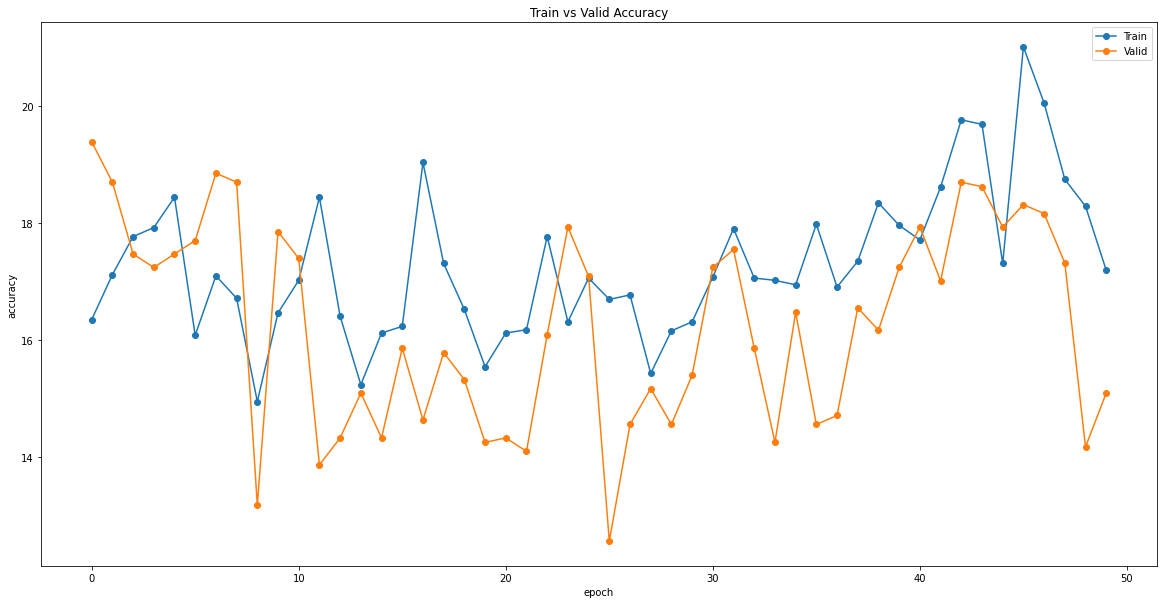

In [32]:
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

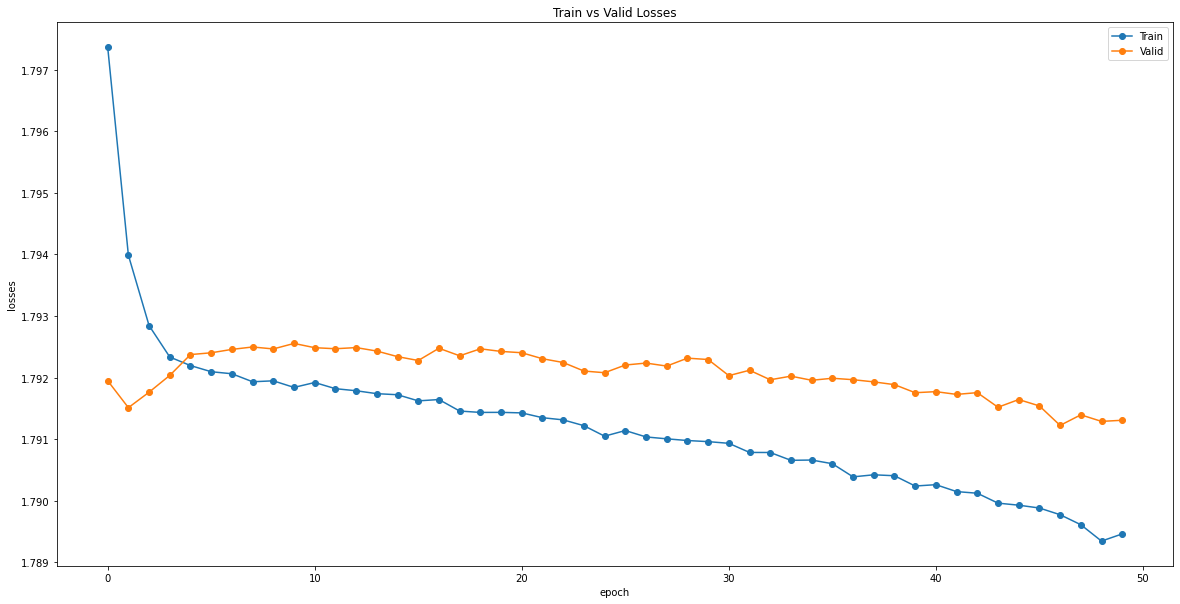

In [33]:
plt.plot(train_losses,'-o')
plt.plot(eval_loss,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

## Testing predictions

In [34]:
labels = sorted(['angry','sad','disgusting','neutral','fear','happy'])
print(labels)

## TODO: Handle different time series data length

riley = librosa.load('./neutral/Recording.wav')
aaa = librosa.load('./neutral/1001_IEO_NEU_XX.wav')

test_data = pd.DataFrame([['./1001_IEO_NEU_XX.wav','neutral']],columns=['name','class'])

test_data = AudioData(test_data)

test_loader = DataLoader(test_data, batch_size=1)

['angry', 'disgusting', 'fear', 'happy', 'neutral', 'sad']


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: ignored

In [ ]:
model.eval()

seed = 0
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

with torch.no_grad():
  for data in tqdm(test_loader):
    inputs,labels=data[0].to(device),data[1].to(device)
    print(inputs.shape,labels)

    outputs = model(inputs.float())
    _, predicted = outputs.max(1)
    classes = sorted(['angry','sad','disgusting','neutral','fear','happy'])
    print(predicted,classes[predicted])